In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, concatenate, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
import numpy as np
import tensorflow_hub as hub
import cv2
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
import sklearn

In [ ]:
random_number = 42

In [ ]:
tf.keras.utils.set_random_seed(random_number)

In [ ]:
images_dir = 'E:/Skola/agileML/resized/'

In [ ]:
pairs = pd.read_csv("C:/Users/petrz/sprint 5/pairs3.csv")

In [ ]:
pairs['Path 1'] = images_dir + pairs['Path 1']
pairs['Path 2'] = images_dir + pairs['Path 2']

In [ ]:
pairs["Label"].value_counts()

1    3001
0    3001
Name: Label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(pairs, stratify=pairs["Label"], test_size=0.1, shuffle = True, random_state = random_number)

In [ ]:
 def get_image_array(filename):
        image_string = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image_string)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = image/255.0
        return image


In [ ]:
x_train_ = []
y_train_ = []
x_val_ = []
y_val_ = []

for pair, row in train_df.iterrows():
    image1 = get_image_array(row["Path 1"])
    image2 = get_image_array(row["Path 2"])
    x_train_.append([image1,image2])
    y_train_.append(int(row["Label"]))
    
for pair, row in val_df.iterrows():
    image1 = get_image_array(row["Path 1"])
    image2 = get_image_array(row["Path 2"])
    x_val_.append([image1,image2])
    y_val_.append(int(row["Label"]))
    
x_train = np.array(x_train_)
y_train = np.array(y_train_)
x_val = np.array(x_val_)
y_val = np.array(y_val_)


In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [ ]:
import os
os.environ["TFHUB_CACHE_DIR"] = "E:/Skola/agileML/cache"
hub_extractor = "https://tfhub.dev/google/bit/m-r50x1/1"



In [ ]:
feature_extractor_layer = hub.KerasLayer(
    hub_extractor,
    input_shape=(224, 224, 3),
    trainable=False)


In [ ]:
def initialize_base_network():
    input = Input(shape=(224,224,3))
    x = feature_extractor_layer(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

In [ ]:
base_network = initialize_base_network()

In [ ]:
input_a = Input(shape=(224,224,3), name="left_input")
vect_output_a = base_network(input_a)
input_b = Input(shape=(224,224,3), name="right_input")
vect_output_b = base_network(input_b)
output = Lambda(euclidean_distance, name="output_layer")([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [ ]:
%%time
model.compile(loss=contrastive_loss_with_margin(1.0), optimizer=Adam())
history = model.fit(
    [x_train[:,0],
    x_train[:,1]],
    y_train,
    batch_size=16,
    verbose=1,
    validation_data=([x_val[:,0],x_val[:,1]],y_val), 
    epochs=20,
    callbacks=[callback]
)
model.save_weights('E:/Skola/agileML/sprint 5/model/weights')
model.save('E:/Skola/agileML/sprint 5/model/model')


Epoch 1/20
338/338 [==============================] - 2023s 6s/step - loss: 0.2723 - val_loss: 0.2424
Epoch 2/20
338/338 [==============================] - 1941s 6s/step - loss: 0.2412 - val_loss: 0.2352
Epoch 3/20
338/338 [==============================] - 1912s 6s/step - loss: 0.2297 - val_loss: 0.2276
Epoch 4/20
338/338 [==============================] - 1955s 6s/step - loss: 0.2187 - val_loss: 0.2335
Epoch 5/20
338/338 [==============================] - 1977s 6s/step - loss: 0.2135 - val_loss: 0.2326
Epoch 6/20
338/338 [==============================] - 2024s 6s/step - loss: 0.2053 - val_loss: 0.2290
INFO:tensorflow:Assets written to: E:/Skola/agileML/sprint 5/model/model\assets


INFO:tensorflow:Assets written to: E:/Skola/agileML/sprint 5/model/model\assets


CPU times: total: 14h 54min 25s
Wall time: 3h 18min 16s


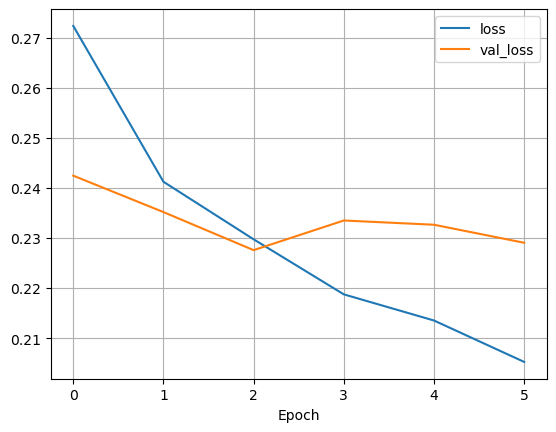

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.legend()
plt.grid(True)


In [ ]:
left_image = x_val[:,0]
left_image_feature_vectors = base_network.predict(left_image)


19/19 [==============================] - 90s 5s/step


In [ ]:
right_image = x_val[:,1]
right_image_feature_vectors = base_network.predict(right_image)

19/19 [==============================] - 88s 5s/step


In [ ]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

In [ ]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
pd.Series(positive_distances).describe()


count    301.000000
mean       0.484496
std        0.174825
min        0.170524
25%        0.354238
50%        0.460403
75%        0.581384
max        1.128663
dtype: float64

In [ ]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
pd.Series(negative_distances).describe()


count    300.000000
mean       0.540889
std        0.195787
min        0.162703
25%        0.395736
50%        0.518387
75%        0.644660
max        1.186241
dtype: float64

In [ ]:
border = abs(np.mean(pd.Series(positive_distances)) + np.mean(pd.Series(negative_distances)))/2
print(border)

0.512692466378212


In [ ]:
def compute_accuracy(y_true, y_pred):
    # 1 for the same - distance is smaller than 0.5, 0 for the different
    y_true = tf.cast(y_true, tf.float32)
    pred = y_pred.flatten() < 0.5
    return np.mean(pred == y_true)


In [ ]:
y_pred_test = model.predict([x_val[:,0], x_val[:,1]])
test_accuracy = compute_accuracy(y_val, y_pred_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

19/19 [==============================] - 165s 9s/step
Test accuracy: 63.39%
